In [ ]:
using Pkg
Pkg.add("Distributions")
Pkg.add("GR")
Pkg.add("FFTW")

using Distributions
using GR
using AbstractFFTs

In [2]:
num_photons = 100
num_pixels  = 256
#mu_p        = num_photons * np.ones((num_pixels, num_pixels))
println("wer")

function fnc_1()
    num_photons = 500
    num_pixels  = 256
    A = num_photons * ones(Integer,num_pixels,num_pixels)
    x = Array(1:num_pixels)
    y = Array(1:num_pixels)
    z = A[x,y]

    heatmap(A)
end

#fnc_1()

function fnc_2()
    num_photons = 500
    num_pixels  = 256
    seed       = 42
    #rs         = np.random.RandomState(seed)
    A = num_photons * ones(Float64,num_pixels,num_pixels)
    x = Poisson(num_photons)
    for i in 1:num_pixels
        for j in 1:num_pixels
            A[i,j] = rand(x)
        end
    end
    heatmap(A)
    histogram(A; nbins = 650-350)
    #shot_noise = rs.poisson(num_photons, (num_pixels, num_pixels))

    #fig, (ax0, ax1) = plt.subplots(ncols=2)
    #img0 = ax0.imshow(mu_p, vmin=400, vmax=600)
    #ax0.set_xticks([])
    #ax0.set_yticks([])
    #ax0.set_title('No shot noise')

    #divider = make_axes_locatable(ax0)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb0 = plt.colorbar(img0, cax=cax)
    #cb0.set_ticks([])

    #img1 = ax1.imshow(shot_noise, vmin=400, vmax=600)
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    #ax1.set_title('Shot noise')

    #divider = make_axes_locatable(ax1)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    #cb1 = plt.colorbar(img1, cax=cax)
    #cb1.set_label('Photons')
end

function fnc_3()
    num_photons = 500
    num_pixels  = 256
    seed       = 42
    quantum_efficiency = 0.69

    dark_noise = 2.29

    #rs         = np.random.RandomState(seed)
    shot_noise = num_photons * ones(Float64,num_pixels,num_pixels)
    electrons = ones(Float64,num_pixels,num_pixels)
    dark_noise_dist = ones(Float64,num_pixels,num_pixels)
    elex_plus_darknoise = ones(Float64,num_pixels,num_pixels)

    x = Poisson(num_photons)
    norm = Normal(dark_noise)

    for i in 1:num_pixels
        for j in 1:num_pixels
            elem = rand(x)
            shot_noise[i,j] = elem
            electrons[i,j] = round((quantum_efficiency * elem), digits=3)
            #dark_noise_dist = rand(norm);
            elex_plus_darknoise[i,j] = rand(norm) + electrons[i,j]
        end
    end

    electrons

    #heatmap(shot_noise, clim=[200.,600.])
    #heatmap(electrons, clim=[200.,600.])
    heatmap(elex_plus_darknoise, clim=[200.,600.])
end

"""
dist takes the pixel position (x, y) and returns the frequency
"""
function noise(title::String, dist, pixels=256)
    A = [dist(x, y) for  x in 1:pixels, y in 1:pixels]
    h = heatmap(A, title=title, ylabel="Photons")
end

wer


noise

In [ ]:
# Ground truth: a circular phase-only object
numPixels = 512
gtRadius  = 50 # ground truth radius, pixels
gtPhase   = 0.75 # radians
gtCenter  = numPixels / 2 # assumes numPixels is even

W = [y for x=0:numPixels-1, y=0:numPixels-1]
H = [x for x=0:numPixels-1, y=0:numPixels-1]
gtMask = [sqrt((W[x, y] - gtCenter)^2 + (H[x, y] - gtCenter)^2) <= gtRadius for x=1:numPixels, y=1:numPixels]

# boolean matrix
gtMask    = np.sqrt((W - gtCenter)**2 + (H - gtCenter)**2) <= gtRadius # boundaries of the object

# complex matrix
gt = ones(ComplexF64, numPixels, numPixels)

# Unclear, doesn't change the value of gt or gtMask in Python, when tested
# everything false 
# gt[gtMask] = np.exp(1j * gtPhase)

# Physical dimensions and sampling
pixelSize = 0.1 # microns

x = range(-pixelSize * numPixels / 2, pixelSize * numPixels / 2, length = numPixels)
dx = x[2] - x[1]    # Sampling period, microns
fS = 1 / dx         # Spatial sampling frequency, inverse microns
df = fS / numPixels # Spacing between discrete frequency coordinates, inverse microns
fx = collect(-fS/2:df:fS/2) # Spatial frequency, inverse microns

# Fourier transform of ground truth
GT = ifftshift(fft(fftshift(gt))) * dx^2

# TODO: Wird nur in animate verwendet, wird das gebraucht?
# Angular spectrum propagator and spatial frequencies
#function H_FN(fx, fy, z, wavelength=0.5)
#    square_root = sqrt(1 - (wavelength^2 * fx^2) - (wavelength^2 * fy^2))
#    temp = exp(1j * 2 * pi * z / wavelength * square_root)
#    temp[np.isnan(temp)] = 0 # replace nan's with zeros
#    return temp
#end

# All rows have the fx vector
# a b
# a b
FX = [x for y=1:length(fx),x in fx]

# All columns have the fx vector
# a a 
# b b
FY = [x for x in fx, y=1:length(fx)]

# Field at a distance of z=0
gt_prime = fftshift(ifft(ifftshift(GT))) / dx^2

# Normalizing constant: makes the maximum photon count at z = 0 equal to 100 photons
maxVal, _ = findmax([abs(x)^2 for x in gt_prime])
norm = maxVal / 100

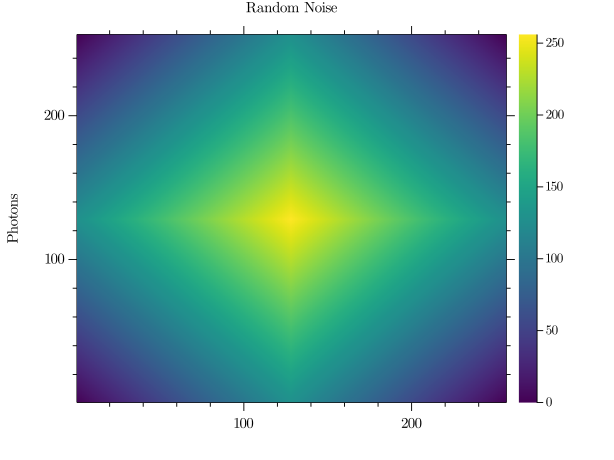

In [7]:
noise("Random Noise", (x::Integer, y::Integer) -> 256//2-abs(256//2-y) + 256//2-abs(256//2-x))

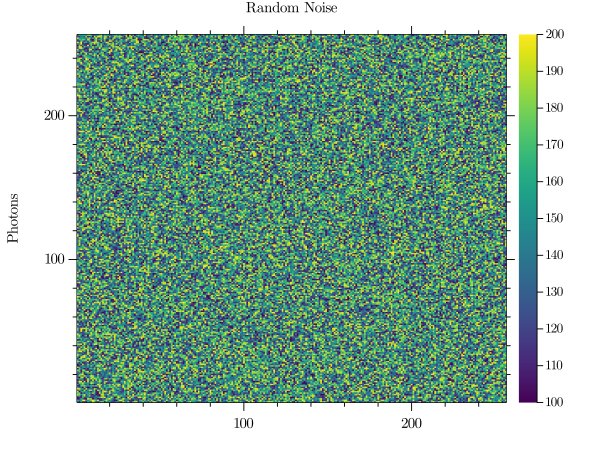

In [8]:
noise("Random Noise", (x::Integer, y::Integer) -> rand(100:200))

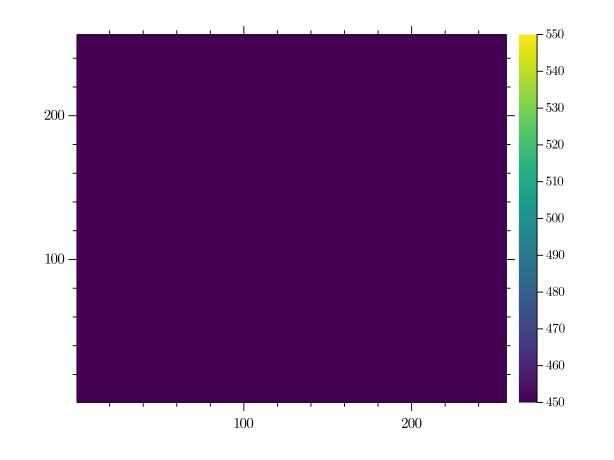

In [9]:
fnc_1()

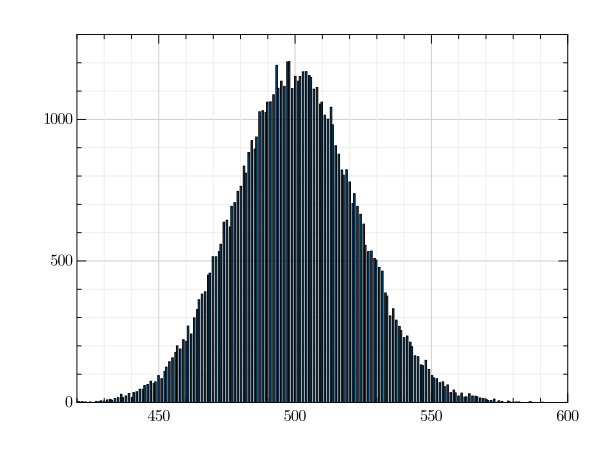

In [10]:
fnc_2()

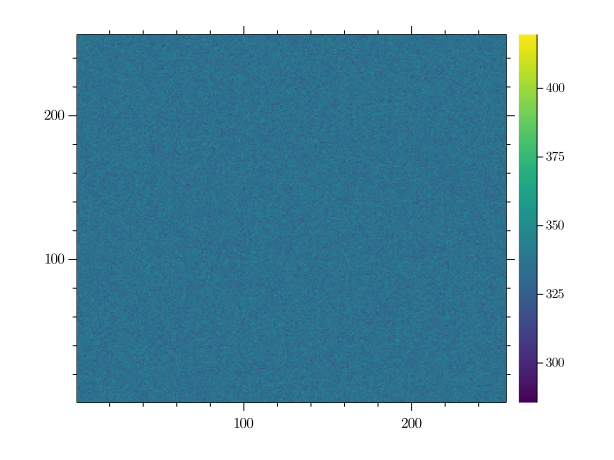

In [11]:
fnc_3()